In [3]:
import pandas as pd

In [49]:
import os
directory = "workspace"
data = pd.read_csv(os.path.join(directory,"Energy_Data_prepared2.csv"))
data.head()

,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,DA_Price
0,2020-09-20T00:00:00.000000+0000,20.06,0.0,2130.537493,2228.208777,996.284,2.50,32.17
1,2020-09-20T00:30:00.000000+0000,19.77,0.0,2130.537493,2228.208777,957.576,15.00,32.17
2,2020-09-20T01:00:00.000000+0000,28.68,0.0,2130.537493,2228.208777,941.044,47.95,32.00
3,2020-09-20T01:30:00.000000+0000,28.97,0.0,2130.537493,2228.208777,964.366,29.13,32.00
4,2020-09-20T02:00:00.000000+0000,28.19,0.0,2130.537493,2228.208777,918.432,28.95,31.99


In [69]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Nettoyage des données
data.fillna(method='ffill', inplace=True)

# Choix de la colonne à prédire
target_column = ['Wind_MW', 'Solar_MW']
features = ['Wind_MW', 'Solar_MW','Solar_capacity_mwp','Solar_installedcapacity_mwp']

# Préparation des données
dataset = data[features].values
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset_scaled = scaler.fit_transform(dataset)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(data[features])  # Ajuster le scaler sur toutes les caractéristiques

Y_scaled = scaler.fit_transform(data[target_column].values.reshape(-1, 1))  # Ensure two-dimensional input

# Fonction pour créer des séquences
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 3
X, Y = create_dataset(dataset_scaled, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], len(features)))  # Correct number of features

# Séparation en ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Création du modèle LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, len(features))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=20, batch_size=32, verbose=2)

# Prédictions et évaluation
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Fix: Use a single column for inverse transform for Y_train and Y_test
Y_train_inv = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

train_score = mean_squared_error(Y_train_inv, train_predict)
test_score = mean_squared_error(Y_test_inv, test_predict)

print(f'Train Score: {train_score:.2f} MSE')
print(f'Test Score: {test_score:.2f} MSE')

Epoch 1/20


/tmp/ipykernel_2304/4069255344.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1460/1460 - 4s - 3ms/step - loss: 0.0087
Epoch 2/20
1460/1460 - 3s - 2ms/step - loss: 0.0026
Epoch 3/20
1460/1460 - 3s - 2ms/step - loss: 0.0024
Epoch 4/20
1460/1460 - 3s - 2ms/step - loss: 0.0024
Epoch 5/20
1460/1460 - 3s - 2ms/step - loss: 0.0023
Epoch 6/20
1460/1460 - 2s - 2ms/step - loss: 0.0023
Epoch 7/20
1460/1460 - 2s - 2ms/step - loss: 0.0023
Epoch 8/20
1460/1460 - 2s - 2ms/step - loss: 0.0023
Epoch 9/20
1460/1460 - 2s - 2ms/step - loss: 0.0023
Epoch 10/20
1460/1460 - 2s - 2ms/step - loss: 0.0023
Epoch 11/20
1460/1460 - 3s - 2ms/step - loss: 0.0023
Epoch 12/20
1460/1460 - 3s - 2ms/step - loss: 0.0023
Epoch 13/20
1460/1460 - 3s - 2ms/step - loss: 0.0023
Epoch 14/20
1460/1460 - 3s - 2ms/step - loss: 0.0023
Epoch 15/20
1460/1460 - 2s - 2ms/step - loss: 0.0022
Epoch 16/20
1460/1460 - 2s - 2ms/step - loss: 0.0022
Epoch 17/20
1460/1460 - 2s - 2ms/step - loss: 0.0022
Epoch 18/20
1460/1460 - 2s - 2ms/step - loss: 0.0022
Epoch 19/20
1460/1460 - 2s - 2ms/step - loss: 0.0022
Epoch 20/20
1

In [70]:
import math

# Calcul du RMSE
train_rmse = math.sqrt(train_score)
test_rmse = math.sqrt(test_score)

# Affichage des résultats
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 84.95
Test RMSE: 88.28


In [26]:
# Supposons que vous avez un DataFrame appelé 'data' contenant vos données d'entraînement
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(data[features])  # Ajuster le scaler sur toutes les caractéristiques

# Supposons que `new_data` soit vos nouvelles données sous forme de DataFrame
new_data = pd.read_csv(os.path.join(directory,"Energy_Data.csv"))
new_features = new_data[features].values
new_features_scaled = scaler.transform(new_features)

# Créer des séquences de la même manière que pour l'entraînement
look_back = 3  # Doit être le même que celui utilisé lors de l'entraînement
def create_predict_sequences(dataset, look_back):
    X = []
    for i in range(len(dataset) - look_back + 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
    return np.array(X)

X_predict = create_predict_sequences(new_features_scaled, look_back)
X_predict = np.reshape(X_predict, (X_predict.shape[0], look_back, len(features)))


/usr/local/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [43]:
predicted_energy = model.predict(X_predict)
predicted_energy = scaler.inverse_transform(predicted_energy)  # Inverse scaling


1824/1824 ━━━━━━━━━━━━━━━━━━━━ 2s 989us/step


In [44]:
import pandas as pd

# Conversion de la colonne 'dtm' en datetime si ce n'est pas déjà fait
data['dtm'] = pd.to_datetime(data['dtm'])

# Si les prédictions correspondent aux 'n' dernières entrées
n_predictions = len(predicted_energy)
date_range = data['dtm'][-n_predictions:]  # Extrait les dates pour les prédictions

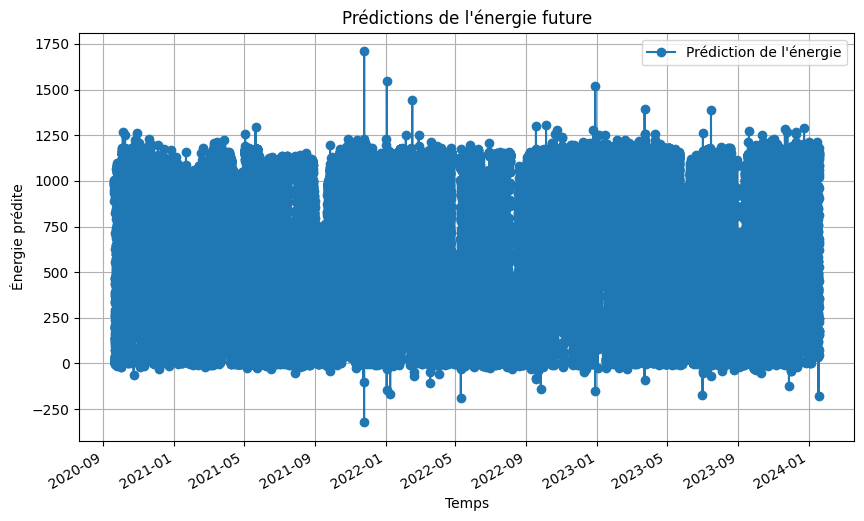

In [55]:
# le graphique qui est nul

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot(date_range, predicted_energy, label='Prédiction de l\'énergie', marker='o')
plt.title('Prédictions de l\'énergie future')
plt.xlabel('Temps')
plt.ylabel('Énergie prédite')

# Configuration des formats de date sur l'axe des abscisses
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()  # Rotation pour mieux afficher les dates

plt.legend()
plt.grid(True)
plt.show()
